# Chicago Divvy Bicycle Sharing Data

#### Link Kaggle
https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

#### Descrição das features:
<br><b>trip_idID</b> attached to each trip taken
<br><b>year</b>
<br><b>month</b>
<br><b>week</b> week No.
<br><b>day</b> 
<br><b>hour</b> 
<br><b>usertype</b> "Customer" is a rider who purchased a 24-Hour Pass; "Subscriber" is a rider who purchased an Annual Membership
<br><b>gender</b>
<br><b>starttimeday</b> and time trip started, in CST
<br><b>stoptimeday</b> and time trip ended, in CST
<br><b>tripdurationtime</b> of trip in minutes
<br><b>temperature</b>
<br><b>events</b>
<br><b>from_station_idID</b> of station where trip originated
<br><b>from_station_namename</b> of station where trip terminated
<br><b>latitude_startstation</b> latitude
<br><b>longitude_startstation</b> longitude
<br><b>dpcapacity_startnumber</b> of total docks at each station
<br><b>to_station_id</b>
<br><b>to_station_name</b>
<br><b>latitude_end</b>
<br><b>longitude_end</b>
<br><b>dpcapacity_endnumber</b> of total docks at each station

### Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, BatchNormalization, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, TensorBoard
import tensorflow as tf


#warnings.filterwarnings('ignore')

C:\Users\henrique\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Carregar dataset

In [3]:
#Carregar dataset
path = "data.csv"
df = pd.read_csv(path)

df.shape

(9495235, 23)

### Correções

In [4]:
#Corringindo campo day com 0
df.day =  df.starttime.astype(str).str.slice(8,10).astype(int)

### Novas Features

In [5]:
#Campo data
df['date'] = df.starttime.astype(str).str[:13]  + ':00:00'

#Convertendo para datetime
df.date = pd.to_datetime(df.date)

### Consolidando dados

In [6]:
#Agregação por date
df2 =  df.groupby(['date']).size().reset_index(name='count')

#Date como index
df2.index = df2['date']
del df2['date']

df2.head(5)
df2.tail(5)

,count
date,
2017-12-31 17:00:00,38
2017-12-31 18:00:00,27
2017-12-31 20:00:00,19
2017-12-31 22:00:00,9
2017-12-31 23:00:00,7


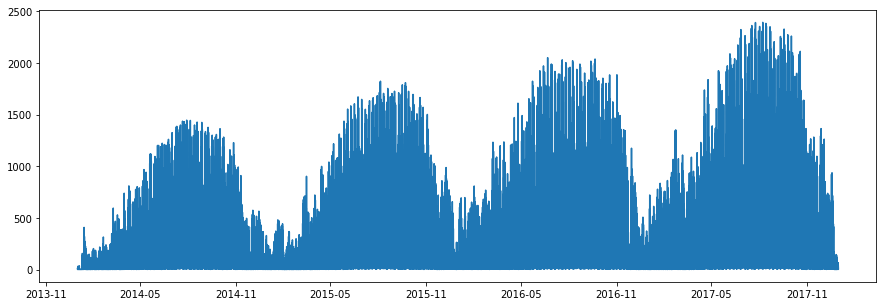

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(df2)
plt.show()

### Normalizando features

In [8]:
values = df2['count'].values.reshape(-1,1)
values = values.astype('float32')
f_norm = MinMaxScaler(feature_range=(0, 1))
v_norm = f_norm.fit_transform(values)

### Particionando Sets

In [9]:
#Definindo o tamanho de cada set
train_size = int(len(v_norm) * 0.8)
test_size  = (5*24)
val_size   = len(v_norm) - train_size - test_size

#Particionando os sets
train = v_norm[0:train_size,:]
val   = v_norm[train_size:(train_size+val_size),:]
test  = v_norm[(train_size+val_size):len(v_norm),:]

#Volume de dados
print('Train:', len(train))
print('Val:  ', len(val))
print('Test: ', len(test))

Train: 27693
Val:   6804
Test:  120


### Definindo Modelo

In [12]:
batch_size=2
time_steps=24

trainGenerator = TimeseriesGenerator(train, train,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
valGenerator = TimeseriesGenerator(val,  val,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
testGenerator = TimeseriesGenerator(test,  test,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)

#Reshape
#trainX_ = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#valX_   = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

#Dfinindo modelo LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(time_steps, train.shape[1])))

#model.add(Dropout(0.25))
#model.add(Dense(128))
#model.add(BatchNormalization())

model.add(Dense(1))

print(model.summary())

#Compilando Modelo
model.compile(loss='mean_squared_error', optimizer='adam')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None


### Treinando Modelo

In [13]:
epochs = 1000
batch_size = 300

fit = True


if fit: 
    #Fit nos dados
    history = model.fit_generator(trainGenerator, 
                        steps_per_epoch= 30, 
                        epochs = epochs,
                        validation_data = valGenerator,
                        callbacks=[
                            EarlyStopping(patience=100),
                            ModelCheckpoint('best.3.h5', save_best_only=True, save_weights_only=True, verbose=1),
                            TensorBoard(log_dir="c:/tensor_log/", write_graph=True)
                        ])
else:
    model.load_weights('best.3.h5')

Epoch 1/1000
30/30 [==============================] - 15s 514ms/step - loss: 0.0075 - val_loss: 0.0357

Epoch 00001: val_loss improved from inf to 0.03573, saving model to best.3.h5
Epoch 2/1000
30/30 [==============================] - 15s 503ms/step - loss: 0.0128 - val_loss: 0.0247

Epoch 00002: val_loss improved from 0.03573 to 0.02466, saving model to best.3.h5
Epoch 3/1000
30/30 [==============================] - 15s 500ms/step - loss: 0.0114 - val_loss: 0.0216

Epoch 00003: val_loss improved from 0.02466 to 0.02161, saving model to best.3.h5
Epoch 4/1000
30/30 [==============================] - 16s 531ms/step - loss: 0.0073 - val_loss: 0.0230

Epoch 00004: val_loss did not improve from 0.02161
Epoch 5/1000
30/30 [==============================] - 16s 526ms/step - loss: 0.0078 - val_loss: 0.0189

Epoch 00005: val_loss improved from 0.02161 to 0.01886, saving model to best.3.h5
Epoch 6/1000
30/30 [==============================] - 15s 503ms/step - loss: 0.0030 - val_loss: 0.0190

E

30/30 [==============================] - 14s 453ms/step - loss: 0.0033 - val_loss: 0.0070

Epoch 00049: val_loss improved from 0.00707 to 0.00696, saving model to best.3.h5
Epoch 50/1000
30/30 [==============================] - 14s 457ms/step - loss: 0.0021 - val_loss: 0.0069

Epoch 00050: val_loss improved from 0.00696 to 0.00687, saving model to best.3.h5
Epoch 51/1000
30/30 [==============================] - 14s 479ms/step - loss: 0.0024 - val_loss: 0.0082

Epoch 00051: val_loss did not improve from 0.00687
Epoch 52/1000
30/30 [==============================] - 14s 459ms/step - loss: 0.0045 - val_loss: 0.0067

Epoch 00052: val_loss improved from 0.00687 to 0.00671, saving model to best.3.h5
Epoch 53/1000
30/30 [==============================] - 14s 462ms/step - loss: 0.0040 - val_loss: 0.0068

Epoch 00053: val_loss did not improve from 0.00671
Epoch 54/1000
30/30 [==============================] - 14s 457ms/step - loss: 0.0024 - val_loss: 0.0070

Epoch 00054: val_loss did not improv

30/30 [==============================] - 14s 458ms/step - loss: 0.0021 - val_loss: 0.0045

Epoch 00098: val_loss improved from 0.00450 to 0.00446, saving model to best.3.h5
Epoch 99/1000
30/30 [==============================] - 14s 454ms/step - loss: 0.0017 - val_loss: 0.0045

Epoch 00099: val_loss did not improve from 0.00446
Epoch 100/1000
30/30 [==============================] - 14s 456ms/step - loss: 0.0019 - val_loss: 0.0050

Epoch 00100: val_loss did not improve from 0.00446
Epoch 101/1000
30/30 [==============================] - 14s 462ms/step - loss: 0.0034 - val_loss: 0.0050

Epoch 00101: val_loss did not improve from 0.00446
Epoch 102/1000
30/30 [==============================] - 14s 457ms/step - loss: 9.8382e-04 - val_loss: 0.0044

Epoch 00102: val_loss improved from 0.00446 to 0.00442, saving model to best.3.h5
Epoch 103/1000
30/30 [==============================] - 14s 458ms/step - loss: 0.0013 - val_loss: 0.0051

Epoch 00103: val_loss did not improve from 0.00442
Epoch 10

30/30 [==============================] - 14s 469ms/step - loss: 0.0017 - val_loss: 0.0058

Epoch 00149: val_loss did not improve from 0.00397
Epoch 150/1000
30/30 [==============================] - 13s 450ms/step - loss: 0.0015 - val_loss: 0.0061

Epoch 00150: val_loss did not improve from 0.00397
Epoch 151/1000
30/30 [==============================] - 13s 446ms/step - loss: 0.0032 - val_loss: 0.0043

Epoch 00151: val_loss did not improve from 0.00397
Epoch 152/1000
30/30 [==============================] - 14s 456ms/step - loss: 0.0050 - val_loss: 0.0054

Epoch 00152: val_loss did not improve from 0.00397
Epoch 153/1000
30/30 [==============================] - 14s 458ms/step - loss: 0.0019 - val_loss: 0.0051

Epoch 00153: val_loss did not improve from 0.00397
Epoch 154/1000
30/30 [==============================] - 14s 460ms/step - loss: 0.0018 - val_loss: 0.0044

Epoch 00154: val_loss did not improve from 0.00397
Epoch 155/1000
30/30 [==============================] - 14s 455ms/step - 

30/30 [==============================] - 14s 461ms/step - loss: 0.0018 - val_loss: 0.0041

Epoch 00200: val_loss did not improve from 0.00285
Epoch 201/1000
30/30 [==============================] - 14s 470ms/step - loss: 0.0011 - val_loss: 0.0036

Epoch 00201: val_loss did not improve from 0.00285
Epoch 202/1000
30/30 [==============================] - 14s 466ms/step - loss: 9.8742e-04 - val_loss: 0.0033

Epoch 00202: val_loss did not improve from 0.00285
Epoch 203/1000
30/30 [==============================] - 14s 454ms/step - loss: 0.0018 - val_loss: 0.0041

Epoch 00203: val_loss did not improve from 0.00285
Epoch 204/1000
30/30 [==============================] - 14s 457ms/step - loss: 0.0018 - val_loss: 0.0025

Epoch 00204: val_loss improved from 0.00285 to 0.00254, saving model to best.3.h5
Epoch 205/1000
30/30 [==============================] - 14s 458ms/step - loss: 7.0133e-04 - val_loss: 0.0028

Epoch 00205: val_loss did not improve from 0.00254
Epoch 206/1000
30/30 [============

30/30 [==============================] - 14s 459ms/step - loss: 0.0021 - val_loss: 0.0033

Epoch 00252: val_loss did not improve from 0.00254
Epoch 253/1000
30/30 [==============================] - 15s 501ms/step - loss: 0.0028 - val_loss: 0.0027

Epoch 00253: val_loss did not improve from 0.00254
Epoch 254/1000
30/30 [==============================] - 15s 486ms/step - loss: 0.0013 - val_loss: 0.0030

Epoch 00254: val_loss did not improve from 0.00254
Epoch 255/1000
30/30 [==============================] - 14s 469ms/step - loss: 0.0020 - val_loss: 0.0032

Epoch 00255: val_loss did not improve from 0.00254
Epoch 256/1000
30/30 [==============================] - 15s 494ms/step - loss: 0.0016 - val_loss: 0.0034

Epoch 00256: val_loss did not improve from 0.00254
Epoch 257/1000
30/30 [==============================] - 16s 518ms/step - loss: 0.0015 - val_loss: 0.0040

Epoch 00257: val_loss did not improve from 0.00254
Epoch 258/1000
30/30 [==============================] - 15s 490ms/step - 

30/30 [==============================] - 14s 460ms/step - loss: 0.0012 - val_loss: 0.0028

Epoch 00303: val_loss did not improve from 0.00208
Epoch 304/1000
30/30 [==============================] - 14s 463ms/step - loss: 0.0015 - val_loss: 0.0030

Epoch 00304: val_loss did not improve from 0.00208
Epoch 305/1000
30/30 [==============================] - 14s 457ms/step - loss: 0.0014 - val_loss: 0.0025

Epoch 00305: val_loss did not improve from 0.00208
Epoch 306/1000
30/30 [==============================] - 14s 463ms/step - loss: 8.1628e-04 - val_loss: 0.0022

Epoch 00306: val_loss did not improve from 0.00208
Epoch 307/1000
30/30 [==============================] - 14s 453ms/step - loss: 5.2761e-04 - val_loss: 0.0022

Epoch 00307: val_loss did not improve from 0.00208
Epoch 308/1000
30/30 [==============================] - 14s 482ms/step - loss: 6.9219e-04 - val_loss: 0.0022

Epoch 00308: val_loss did not improve from 0.00208
Epoch 309/1000
30/30 [==============================] - 14s 4

30/30 [==============================] - 14s 466ms/step - loss: 0.0013 - val_loss: 0.0033

Epoch 00355: val_loss did not improve from 0.00199
Epoch 356/1000
30/30 [==============================] - 14s 466ms/step - loss: 0.0014 - val_loss: 0.0026

Epoch 00356: val_loss did not improve from 0.00199
Epoch 357/1000
30/30 [==============================] - 14s 459ms/step - loss: 0.0010 - val_loss: 0.0027

Epoch 00357: val_loss did not improve from 0.00199
Epoch 358/1000
30/30 [==============================] - 14s 463ms/step - loss: 0.0018 - val_loss: 0.0036

Epoch 00358: val_loss did not improve from 0.00199
Epoch 359/1000
30/30 [==============================] - 14s 459ms/step - loss: 0.0020 - val_loss: 0.0031

Epoch 00359: val_loss did not improve from 0.00199
Epoch 360/1000
30/30 [==============================] - 14s 460ms/step - loss: 0.0019 - val_loss: 0.0030

Epoch 00360: val_loss did not improve from 0.00199
Epoch 361/1000
30/30 [==============================] - 14s 456ms/step - 

30/30 [==============================] - 14s 477ms/step - loss: 8.9008e-04 - val_loss: 0.0021

Epoch 00406: val_loss did not improve from 0.00183
Epoch 407/1000
30/30 [==============================] - 14s 473ms/step - loss: 0.0010 - val_loss: 0.0031

Epoch 00407: val_loss did not improve from 0.00183
Epoch 408/1000
30/30 [==============================] - 14s 466ms/step - loss: 0.0011 - val_loss: 0.0026

Epoch 00408: val_loss did not improve from 0.00183
Epoch 409/1000
30/30 [==============================] - 14s 459ms/step - loss: 0.0048 - val_loss: 0.0056

Epoch 00409: val_loss did not improve from 0.00183
Epoch 410/1000
30/30 [==============================] - 14s 460ms/step - loss: 0.0013 - val_loss: 0.0052

Epoch 00410: val_loss did not improve from 0.00183
Epoch 411/1000
30/30 [==============================] - 14s 459ms/step - loss: 0.0030 - val_loss: 0.0037

Epoch 00411: val_loss did not improve from 0.00183
Epoch 412/1000
30/30 [==============================] - 14s 459ms/ste

30/30 [==============================] - 14s 457ms/step - loss: 6.0926e-04 - val_loss: 0.0024

Epoch 00458: val_loss did not improve from 0.00183
Epoch 459/1000
30/30 [==============================] - 14s 456ms/step - loss: 0.0037 - val_loss: 0.0042

Epoch 00459: val_loss did not improve from 0.00183
Epoch 460/1000
30/30 [==============================] - 14s 471ms/step - loss: 0.0012 - val_loss: 0.0035

Epoch 00460: val_loss did not improve from 0.00183
Epoch 461/1000
30/30 [==============================] - 14s 457ms/step - loss: 0.0012 - val_loss: 0.0037

Epoch 00461: val_loss did not improve from 0.00183
Epoch 462/1000
30/30 [==============================] - 14s 456ms/step - loss: 0.0029 - val_loss: 0.0029

Epoch 00462: val_loss did not improve from 0.00183
Epoch 463/1000
30/30 [==============================] - 13s 449ms/step - loss: 0.0013 - val_loss: 0.0023

Epoch 00463: val_loss did not improve from 0.00183
Epoch 464/1000
30/30 [==============================] - 14s 461ms/ste

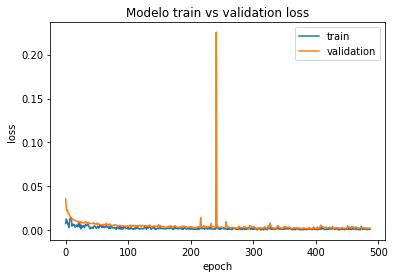

In [14]:
#Plotando
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Predict

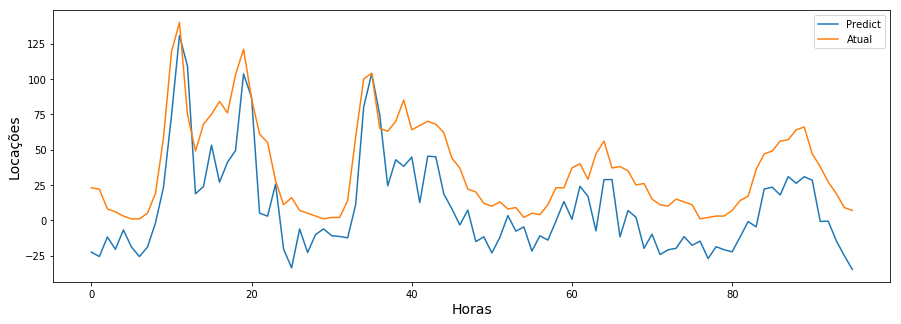

In [15]:
#Reshape test
#testX_ = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Predict
mpred = model.predict_generator(testGenerator)

#Convertendo para valor não normalizado
mpred_inverse = f_norm.inverse_transform(mpred.reshape(-1, 1))
testY_inverse = f_norm.inverse_transform(test.reshape(-1, 1))

#Eixo X do gráfico como data
#predictDates = df2.tail(len(mpred_inverse)).index

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(mpred_inverse, label='Predict')
plt.plot(testY_inverse[time_steps:,], label='Atual')
plt.xlabel('Horas', fontsize=14)
plt.ylabel('Locações', fontsize=14)
plt.legend()
plt.show()

### Previsão a longo prazo

<p>Informaremos 24 horas do set de teste para o modelo, e suas saidas serão incluidas novamente no modelo para tentarmos prever a longo prazo.
<img src="prevlp_1.png">

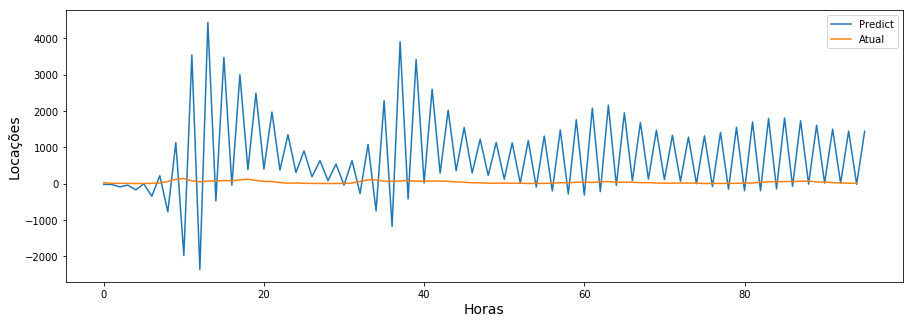

In [16]:
#Quantidade de itens para o set inicial (número de horas: 24)
batch_size=1
time_steps=24

#Inicialização vetor que armazenará as 24 iniciais 
predX = []

#N itens do set de test (time_steps)
predX = test[:(time_steps+batch_size)]
np.array(predX)

#Loop para alimentar o predict
for i in range(len(test)-time_steps):
    #Criando generator sempre com as ultimas 25 horas do array
    testGenerator_ = TimeseriesGenerator(predX[-(time_steps+batch_size):,],  predX[-(time_steps+batch_size):,],
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
    #Predict das ultimas 25 horas
    mpred_lp = model.predict_generator(testGenerator_)
    #Concatenação da hora prevista(1 saida apenas)
    predX = np.append(predX, [mpred_lp])
    predX = np.reshape(predX, (predX.shape[0], 1))
    

#Removendo as 24 horas iniciais do set de teste    
predX = predX[time_steps+batch_size:]

#Convertendo para valor não normalizado
predX_inverse = f_norm.inverse_transform(predX.reshape(-1, 1))

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predX_inverse, label='Predict')
plt.plot(testY_inverse[time_steps+batch_size:,], label='Atual')
plt.xlabel('Horas', fontsize=14)
plt.ylabel('Locações', fontsize=14)
plt.legend()
plt.show()

### Consideramos que o modelo consegue prever até 6 horas com precisão

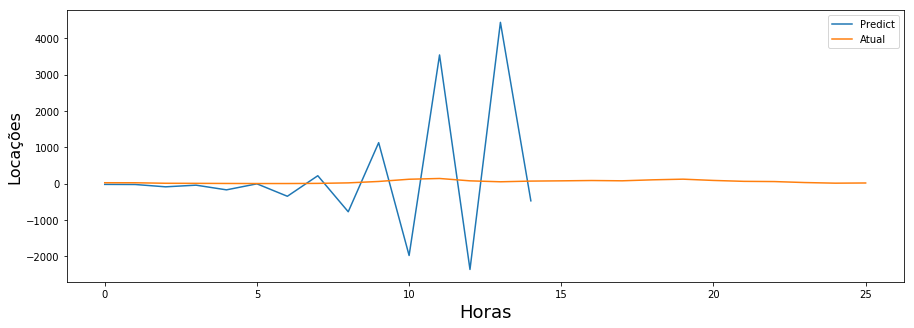

In [17]:
#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predX_inverse[:15], label='Predict')
plt.plot(testY_inverse[time_steps:50,], label='Atual')
plt.xlabel('Horas', fontsize=18)
plt.ylabel('Locações', fontsize=16)
plt.legend()
plt.show()